## FiPy 1D two-phase flow in porous mediaq, 11 October, 2019
Different approaches:
  * Coupled
  * Sequential
  * ...

In [49]:
from fipy import Grid2D, CellVariable, FaceVariable
import numpy as np


def upwindValues(mesh, field, velocity):
    """Calculate the upwind face values for a field variable

    Note that the mesh.faceNormals point from `id1` to `id2` so if velocity is in the same
    direction as the `faceNormal`s then we take the value from `id1`s and visa-versa.

    Args:
      mesh: a fipy mesh
      field: a fipy cell variable or equivalent numpy array
      velocity: a fipy face variable (rank 1) or equivalent numpy array
     
    Returns:
      numpy array shaped as a fipy face variable
    """
    # direction is over faces (rank 0)
    direction = np.sum(np.array(mesh.faceNormals * velocity), axis=0)
    # id1, id2 are shaped as faces but contains cell index values
    id1, id2 = mesh._adjacentCellIDs
    return np.where(direction >= 0, field[id1],  field[id2])


# mesh = Grid2D(nx=3, ny=3)
# print(
#     upwindValues(
#         mesh,
#         np.arange(mesh.numberOfCells),
#         2 * np.random.random(size=(2, mesh.numberOfFaces)) - 1
#     )
# )


In [50]:
from fipy import *

# relperm parameters
swc = 0.1
sor = 0.1
krw0 = 0.3
kro0 = 1.0
nw = 2.0
no = 2.0

# domain and boundaries
k = 1e-12 # m^2
phi = 0.4
u = 1.e-5
p0 = 100e5 # Pa
Lx = 100.
Ly = 10.
nx = 100
ny = 10
dx = Lx/nx
dy = Ly/ny

# fluid properties
muo = 0.002
muw = 0.001

# define the fractional flow functions
def krw(sw):
    res = krw0*((sw-swc)/(1-swc-sor))**nw
    return res

def dkrw(sw):
    res = krw0*nw/(1-swc-sor)*((sw-swc)/(1-swc-sor))**(nw-1)
    return res


def kro(sw):
    res = kro0*((1-sw-sor)/(1-swc-sor))**no
    return res

def dkro(sw):
    res = -kro0*no/(1-swc-sor)*((1-sw-sor)/(1-swc-sor))**(no-1)
    return res

def fw(sw):
    res = krw(sw)/muw/(krw(sw)/muw+kro(sw)/muo)
    return res

def dfw(sw):
    res = (dkrw(sw)/muw*kro(sw)/muo-krw(sw)/muw*dkro(sw)/muo)/(krw(sw)/muw+kro(sw)/muo)**2
    return res

import matplotlib.pyplot as plt
import numpy as np

sw_plot = np.linspace(swc, 1-sor, 50)

## Visualize the relative permeability and fractional flow curves

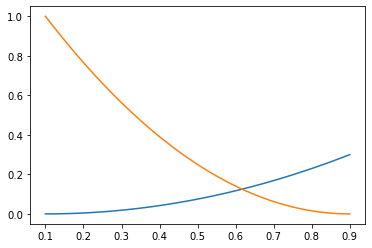

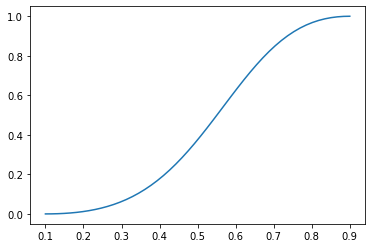

In [51]:
krw_plot = [krw(sw) for sw in sw_plot]
kro_plot = [kro(sw) for sw in sw_plot]
fw_plot = [fw(sw) for sw in sw_plot]

plt.figure(1)
plt.plot(sw_plot, krw_plot, sw_plot, kro_plot)
plt.show()

plt.figure(2)
plt.plot(sw_plot, fw_plot)
plt.show()

In [60]:
# create the grid
mesh = Grid1D(dx = Lx/nx, nx = nx)
x = mesh.cellCenters

# create the cell variables and boundary conditions
sw = CellVariable(mesh=mesh, name="saturation", hasOld=True, value = swc)
p = CellVariable(mesh=mesh, name="pressure", hasOld=True, value = p0)
# sw.setValue(1-sor,where = x<=dx)

sw.constrain(1.0-sor, mesh.facesLeft)
#sw.constrain(0., mesh.facesRight)
sw.faceGrad.constrain([0], mesh.facesRight)
p.faceGrad.constrain([-u/(krw(1-sor)*k/muw)], mesh.facesLeft)
p.constrain(p0, mesh.facesRight)
# p.constrain(3.0*p0, mesh.facesLeft)
u/(krw(1-sor)*k/muw)

33333.333333333336

In [53]:
sw.faceValue

_ArithmeticCellToFaceVariable(value=array([1. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), mesh=UniformGrid1D(dx=1.0, nx=100))

## Equations
$$\nabla.\left(\left(-\frac{k_{rw} k}{\mu_w}-\frac{k_{ro} k}{\mu_o} \right)\nabla p \right)=0$$ or
$$\varphi \frac{\partial S_w}{\partial t}+\nabla.\left(-\frac{k_{rw} k}{\mu_w} \nabla p \right)=0$$

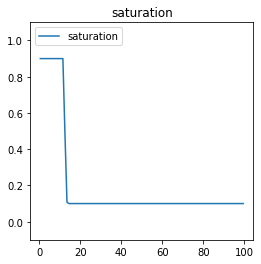

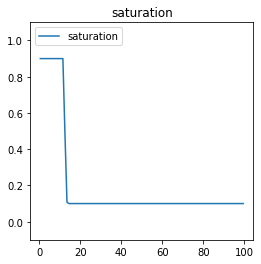

In [61]:
# eq_p = DiffusionTerm(var=p, coeff=-k*(krw(sw.faceValue)/muw+kro(sw.faceValue)/muo))- \
# UpwindConvectionTerm(var=sw, coeff=-k*(dkrw(sw.faceValue)/muw+dkro(sw.faceValue)/muo)*p.faceGrad)- \
# (k*(dkrw(sw.faceValue)/muw+dkro(sw.faceValue)/muo)*sw.faceValue*p.faceGrad).divergence == 0

# eq_sw = TransientTerm(coeff=phi, var=sw) + \
# DiffusionTerm(var=p, coeff=-k*krw(sw.faceValue)/muw)+ \
# UpwindConvectionTerm(var=sw, coeff=-k*dkrw(sw.faceValue)/muw*p.faceGrad)- \
# (-k*dkrw(sw.faceValue)/muw*p.faceGrad*sw.faceValue).divergence == 0

eq_p = DiffusionTerm(var=p, coeff=-k*(krw(sw.faceValue)/muw+kro(sw.faceValue)/muo)) == 0

eq_sw = TransientTerm(coeff=phi, var=sw) + \
(-k*krw(sw.faceValue)/muw*p.faceGrad).divergence == 0

sw_face = sw.faceValue

# eq = eq_p & eq_sw
steps = 100
dt0 = 5000.
dt = dt0
t_end = steps*dt0
t = 0.0
viewer = Viewer(vars = sw, datamax=1.1, datamin=-0.1)
while t<t_end:
    eq_p = DiffusionTerm(var=p, coeff=-k*(krw(sw.faceValue)/muw+kro(sw.faceValue)/muo)) == 0
    eq_p.solve(var=p)
    eq_sw = TransientTerm(coeff=phi, var=sw) + \
        (-k*krw(sw.faceValue)/muw*p.faceGrad).divergence == 0
    eq_sw.solve(var=sw, dt=dt0)
    sw.value[sw.value>1-sor]=1-sor
    sw.value[sw.value<swc]=swc
    p.updateOld()
    sw.updateOld()
    u_w = -k*krw(sw_face)/muw*p.faceGrad
    sw_face = sw.faceValue #FaceVariable(mesh, upwindValues(mesh, sw, u_w))
#     sw_face.value[0] = 1.0
#     eq_p = DiffusionTerm(var=p, coeff=-k*(krw(sw_face)/muw+kro(sw_face)/muo)) == 0
#     eq_sw = TransientTerm(coeff=phi, var=sw) + (-k*krw(sw_face)/muw*p.faceGrad).divergence == 0
    t=t+dt0
        
# Note: try to use the Appleyard method; the overflow is a result of wrong rel-perm values        
viewer.plot()

In [55]:
# sw_face.value
# u_w.value
p.faceGrad

_FaceGradVariable(value=array([[-33333.33333333, -53328.74995397, -55947.35520076,
        -48765.06666518, -43427.97794804, -43056.18892108,
        -43055.55555628, -43055.55555557, -43055.55555556,
        -43055.55555557, -43055.55555557, -43055.55555556,
        -43055.55555556, -43055.55555556, -43055.55555556,
        -64694.69843017, -43274.57465903, -26055.22591197,
        -25833.34059685, -25833.33333334, -25833.33333334,
        -25833.33333334, -25833.33333334, -25833.33333334,
        -25833.33333334, -25833.33333334, -25833.33333334,
        -25833.33333334, -25833.33333334, -25833.33333334,
        -25833.33333334, -25833.33333334, -25833.33333334,
        -25833.33333334, -25833.33333334, -25833.33333334,
        -25833.33333334, -25833.33333334, -25833.33333334,
        -25833.33333334, -25833.33333334, -25833.33333334,
        -25833.33333334, -25833.33333334, -25833.33333334,
        -25833.33333334, -25833.33333334, -25833.33333334,
        -25833.33333333, -25833.

In [59]:
upwindValues(mesh, sw, u_w)
sw.faceValue

_ArithmeticCellToFaceVariable(value=array([1.        , 0.81111051, 0.78475011, 0.84526698, 0.89592566,
       0.89999159, 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.76135615, 0.3699481 , 0.10859296, 0.100001  , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1    

## Analytical solution

In [62]:
import fractional_flow as ff
xt_shock, sw_shock, xt_prf, sw_prf, t, p_inj, R_oil = ff.frac_flow_wf(muw=muw, muo=muo, ut=u, phi=1.0, \
  k=1e-12, swc=swc, sor=sor, kro0=kro0, no=no, krw0=krw0, \
  nw=nw, sw0=swc, sw_inj=1.0, L=Lx, pv_inj=5.0)

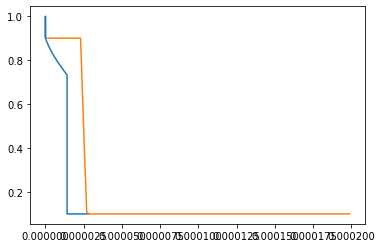

In [63]:
plt.figure()
plt.plot(xt_prf, sw_prf)
plt.plot(x.value.squeeze()/(steps*dt), sw.value)
plt.show()